In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import sklearn.model_selection

In [2]:
#import dataset and look at column names
shot_orig = pd.read_csv('shot_logs.csv')
shot_orig.shape

(128069, 21)

In [3]:
shot_orig.columns

Index(['GAME_ID', 'MATCHUP', 'LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_NUMBER',
       'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT', 'CLOSEST_DEFENDER',
       'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'FGM', 'PTS',
       'player_name', 'player_id'],
      dtype='object')

In [4]:
# Get rid of game_id as it will not contribute my final model

# Get rid of win and final_margin as they are only known after a game is over,
# and I am trying to model shots taken during a game, so they would not contribute to my final.  

# Get rid of player_name, player_id, closest_defender, closest_defender_player_id,matchup, location because
# these are NBA specific, and I would like to generalize to all basketball games.

pre_shot = shot_orig.loc[: , ['SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
                     'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT', 'CLOSE_DEF_DIST', 'PTS']]
pre_shot.head()

,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSE_DEF_DIST,PTS
0,1,1,1:09,10.8,2,1.9,7.7,2,made,1.3,2
1,2,1,0:14,3.4,0,0.8,28.2,3,missed,6.1,0
2,3,1,0:00,NaN,3,2.7,10.1,2,missed,0.9,0
3,4,2,11:47,10.3,2,1.9,17.2,2,missed,3.4,0
4,5,2,10:34,10.9,2,2.7,3.7,2,missed,1.1,0


In [5]:
# find if game_clock refers to the time left in the whole game, or just the period
#pre_shot.GAME_CLOCK

# it seems that none of the time goes above 12, so game_clock refers to just the period

Creating a table based off of shot.dtypes:

| Data Column     | Type        |
| ------------- |:-------------:|
|SHOT_NUMBER   | int64 |
| PERIOD    | int64     |
| GAME_CLOCK | object     |
| SHOT_CLOCK| float64      |
| DRIBBLES | int64      |
| TOUCH_TIME |float64     |
| SHOT_DIST| float64     |
| PTS_TYPE| int64   |
| SHOT_RESULT | object    |
| CLOSE_DEF_DIST| float64     |
| PTS | int64    |

Everything is numeric except for GAME_CLOCK and SHOT_RESULT

In [6]:
# convert game_clock to float
#first replace the colon with a period
pre_shot.GAME_CLOCK = pre_shot.GAME_CLOCK.str.replace(':', '.', regex=True)

#convert game_clock into float
pre_shot.GAME_CLOCK = pre_shot.GAME_CLOCK.astype('float')
type(pre_shot.GAME_CLOCK[1])


numpy.float64

In [7]:
#convert shot_result to bool. 1 if made, 0 if missed
pre_shot.SHOT_RESULT = pre_shot.SHOT_RESULT == 'made'

In [8]:
pre_shot.describe(include = 'all')

,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSE_DEF_DIST,PTS
count,128069.000000,128069.000000,128069.000000,122502.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069,128069.000000,128069.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70164,NaN,NaN
mean,6.506899,2.469427,5.663617,12.453344,2.023355,2.765901,13.571504,2.264670,NaN,4.123015,0.997314
std,4.713260,1.139919,3.451461,5.763265,3.477760,3.043682,8.888964,0.441159,NaN,2.756446,1.130978
min,1.000000,1.000000,0.000000,0.000000,0.000000,-163.600000,0.000000,2.000000,NaN,0.000000,0.000000
25%,3.000000,1.000000,2.520000,8.200000,0.000000,0.900000,4.700000,2.000000,NaN,2.300000,0.000000
50%,5.000000,2.000000,5.520000,12.300000,1.000000,1.600000,13.700000,2.000000,NaN,3.700000,0.000000
75%,9.000000,3.000000,8.510000,16.675000,2.000000,3.700000,22.500000,3.000000,NaN,5.300000,2.000000


Curiously enough, there seems to be a minimum touch time of -163.6, which would clearly be a mistake in the data, as it is impossibe for touch time to be in the negatives.  Some further exploration is required.

In [9]:
len(pre_shot[pre_shot.TOUCH_TIME < 0])

312

Even with only 312 values of touch_time under 0, I decided against deleting all rows were touch time is under 0.  Instead, I will hold onto these values a bit longer and fix them later.

Before further analysis, I will make sure that the distances for 3 point shots and 2 point shots are accurate.  Given how the minimum distance from the hoop to the 3 point line is 22 feet, and the maximum is 23.75, there should ideally be no distances over 23.75 feet for 2 point shots and no distances under 22 feet for 3 point shots.  It is entirely possible, however, that sometimes a player may jump from behind the line and shoot in front of the line, which would decrease the shot distance, but still be a valid 3 point shot.  Therefore, I will set a cutoff at 19 feet for 3 point shots, meaning all distances under 19 feet will be incorrectly labeled as a 3 point shot.

With 2 point shots, it is also possible for players to jump from in front of the 3 point line and shoot the ball behind the line, but that distance should not be nearly as big as jumping forward from behind the line, so I will set a cutoff of 2 point shots at 25, where all distances above 25 feet will be incorrectly labeled as a 2 point shot.

In [10]:
#create a data frame for just 2 point shots and another for just 3 point shots

pre_shot2 = pre_shot[pre_shot['PTS_TYPE'] == 2]
pre_shot3 = pre_shot[pre_shot['PTS_TYPE'] == 3]

# data frame for incorrect distances
pre_incorrect2 = pre_shot2[pre_shot2['SHOT_DIST'] > 25]
pre_incorrect3 = pre_shot3[pre_shot3['SHOT_DIST'] < 19]
print("Number of incorrectly labeled 2 point shots is", len(pre_incorrect2))
print("Number of incorrectly labeled 3 point shots is", len(pre_incorrect3))

Number of incorrectly labeled 2 point shots is 112
Number of incorrectly labeled 3 point shots is 88


For a dataset with 128 thousand rows, these 200 observations isn't too bad.  These observations will be dealt with in a bit.

In [11]:
misvals = pd.DataFrame(pd.DataFrame(pre_shot.describe(include = 'all')).iloc[0, :])
misvals['percentage of missing values'] = (128069 - misvals['count']) / 128069

Creating a table based off of misvals: 

| Data Column     | percentage of missing values      |
| ------------- |:-------------:|
|SHOT_NUMBER   | 0|
| PERIOD    | 0   |
| GAME_CLOCK | 0    |
| SHOT_CLOCK|0.0434688  |
| DRIBBLES | 0    |
| TOUCH_TIME |0   |
| SHOT_DIST| 0   |
| PTS_TYPE| 0   |
| SHOT_RESULT | 0  |
| CLOSE_DEF_DIST|0   |
| PTS |0   |


It seems that all columns except for shot_clock have the full 128069 values.  Shot_clock is only missing less than 5% of its values, so dropping the column would not be considered.

At this point, it seems that there are 3 columns that need cleaning: shot_clock is missing values, touch_time has some nonsensical values, and the pts_type do not completely align with all the shot_dist.  I will proceed by dropping all rows containing 2 or all of these errors.  I chose to do so with only 2 or more errors because, with that many errors, the observation becomes too unreliable.  However, for an observation with only 1 error, I would only need to make adjustments to one variable, which will lead to a less bias in the final model compared to adjustments to multiple variables.

In [12]:
# make array that returns true if there is a discrepancy
pre_discrep2 = (pre_shot.PTS_TYPE == 2) & (pre_shot.SHOT_DIST > 25)
pre_discrep3 = (pre_shot.PTS_TYPE == 3) & (pre_shot.SHOT_DIST < 19)
x = pre_discrep2 | pre_discrep3
print(sum(x), 'observations that have discrepancy in shot distance ')

#array that returns true if there is a missing shot clock value
y = (pre_shot.SHOT_CLOCK != pre_shot.SHOT_CLOCK)
print(sum(y), 'observations that have a missing shot clock value')

# array that returns true if touch time is less than 0
z = (pre_shot.TOUCH_TIME < 0)
print(sum(z), 'observations have negative touch times')

print(sum(x & y), 'observations have a discrepancy in shot distance and a missing shot clock')
print(sum(x & z), 'observations have a discrepancy in shot distance and a negative touch time')
print(sum(y & z), 'observations have a missing shot clock and a negative touch time')
print(sum(x & y & z), 'observations have all three errors')

200 observations that have discrepancy in shot distance 
5567 observations that have a missing shot clock value
312 observations have negative touch times
60 observations have a discrepancy in shot distance and a missing shot clock
7 observations have a discrepancy in shot distance and a negative touch time
13 observations have a missing shot clock and a negative touch time
0 observations have all three errors


Because no observations have all 3 errors, we can add up the last 4 sums to get 80, meaning we should filter out, in total, 80 observations from the original dataset.

In [13]:
# filtering for observations with 2 or more of these errors
xyz = (x & y) | (x & z) | (y & z) | (x & y & z)
print(sum(xyz), 'observations have 2 or more of these errors')

#make an array that returns false if the observation has 2 or more of these errors
filt = [not i for i in xyz]
shot = pre_shot[filt]

#make sure that the new data frame length plus the filtered out observations equals the original data frame length
len(shot) + sum(xyz) == len(pre_shot)

80 observations have 2 or more of these errors


True

After dropping all of these observations, I will now fix the observations that contain only one of these errors.

In [14]:
# I will change the negative touch_time values to 0, as that is the minimum
# amount of time that a player can hold the ball.

shot.TOUCH_TIME[shot.TOUCH_TIME < 0] = 0

/Users/ray/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/ray/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:7620: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/ray/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.us

In [15]:
# find out how many NaN are in shot_clock for the filtered data frame
print(sum(shot.SHOT_CLOCK.isna()), 'observations have missing shot_value, which is', 
          sum(shot.SHOT_CLOCK.isna()) / len(shot.SHOT_CLOCK) * 100, '% of number of observations')

5494 observations have missing shot_value, which is 4.2925563915649 % of number of observations


With only less than 5% of data missing, I will impute the missing data with the mean, as doing so will not contribute to too much bias in the final model.  I opted to use the mean because the range of shot_cock is from 0 to 24, so there will not be any outliers.  Furthermore, as the values are continuous, using mode would not be the best choice.

In [16]:
#fill the NaN in shot_clock with the mean.  
shot[['SHOT_CLOCK']] = shot[['SHOT_CLOCK']].fillna(shot[['SHOT_CLOCK']].mean())

/Users/ray/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


For the observations with discrepancies between the shot distance and the points type, it is unclear whether the discrepancy comes from a mistake in points type, or if it comes from a mistake in shot distance.  I decided to change the points type to match to the shot distance because, given a shot distance in a certain range, you can find out exactly how many points the shot is worth (unless the distance is between 22 and 23.75, but those observations were not counted as errors).

In [17]:
#create filters for pts_type incorrectly labelled as 2 and 3
discrep2 = (shot.PTS_TYPE == 2) & (shot.SHOT_DIST > 25)
discrep3 = (shot.PTS_TYPE == 3) & (shot.SHOT_DIST < 19)

#use filters to change the pts_type to the correct value
shot.loc[discrep2, 'PTS_TYPE'] = 3
shot.loc[discrep3, 'PTS_TYPE'] = 2

/Users/ray/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [18]:
# Check to make sure the labels were changed

#create a data frame for just 2 point shots and another for just 3 point shots for filtered dataframe
shot2 = shot[shot['PTS_TYPE'] == 2]
shot3 = shot[shot['PTS_TYPE'] == 3]

# data frame for incorrect distances
incorrect2 = shot2[shot2['SHOT_DIST'] > 25]
incorrect3 = shot3[shot3['SHOT_DIST'] < 19]
print("Number of incorrectly labeled 2 point shots is", len(incorrect2))
print("Number of incorrectly labeled 3 point shots is", len(incorrect3))

Number of incorrectly labeled 2 point shots is 0
Number of incorrectly labeled 3 point shots is 0


Using the cleaned 'shot' data frame, I will use shot_result as my target column and everything else except pts as my input columns.  I am excluding pts as it details the amount of points resulting from the shot, so it would
not be a good predictor of shot_result.  I am keeping the column, however, because I will use pts for future analysis. 

In [19]:
sum(shot.SHOT_RESULT) / len(shot.SHOT_RESULT)

# The shot_result column is boolean, with 1 being if the shot was made, and 0 being if the shot was missed.  It
# seems that about 45% of all total shots are made.

0.45233574760330963

In [20]:
#create data frame where shot was missed and shot was made for some eda
shot_made = shot.loc[shot['SHOT_RESULT'] == 1, :]
shot_missed = shot.loc[shot['SHOT_RESULT'] == 0, :]

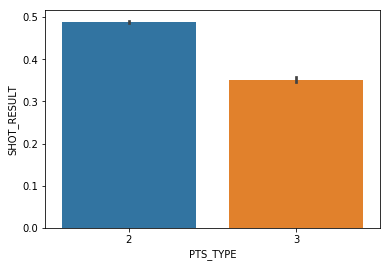

In [21]:
#comparing makes and misses for 2 point shots vs 3 point shots

sns.barplot(x = shot.PTS_TYPE, y = shot.SHOT_RESULT)

#as expected, shots worth 2 points have a much higher percentage (around 49%) than shots worth 3 points (around 35%)

/Users/ray/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


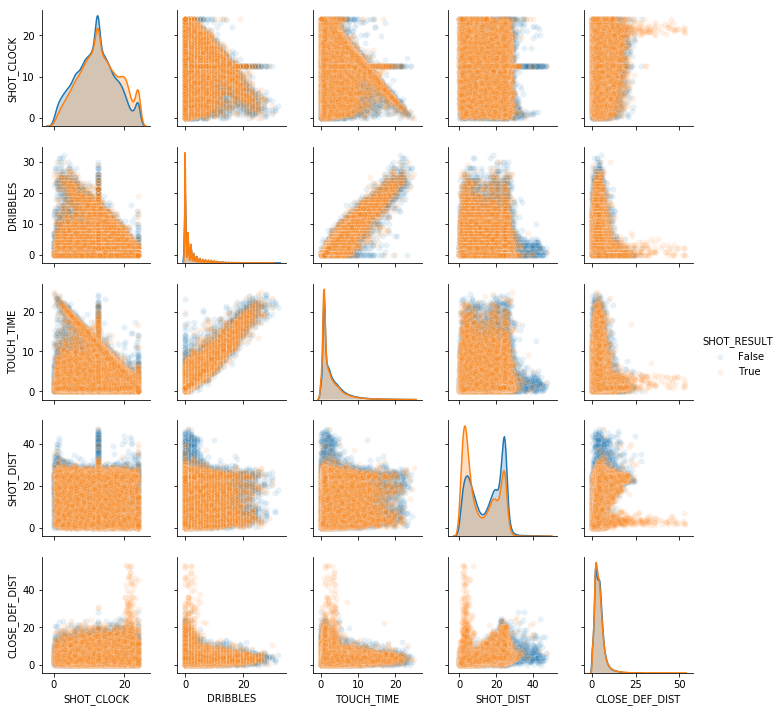

In [22]:
# EDA for a few variables that probably impact probability of shot being made.  I chose for these plots only
# the variables that are have enough variables so a scatterplot makes sense.  These are the continuous variables
# (shot_clock, touch_time, shot_dist, and close_def_dist) and dribbles.  I am choosing to not use game clock as
# it does not mention which period the shot was taken in, so unless the game clock is very low, then it would
# generally not affect the shot as much.  

sns.pairplot(shot, vars = ['SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST'],
             hue="SHOT_RESULT", plot_kws = {'alpha'  : .1}, size = 2)

With so many data points, it is hard to see every single point for both kinds of shot results, but it can be assumed that there are many points where the shot was not made within predominantly orange sections.  The sections that are predominantly blue indicate shots with much more misses than makes, and these are the shots that players and coaches should generally avoid taking.

A few things to note are:

1. Dribbles and touch time before the shot seem to have a strong correlation, which makes sense as taking more dribbles naturally increases your touch time.  Of note are the shots with no dribbles but a long touch time.  These kinds of shots signify a player holding the ball for a while without moving, leading to stagnant offense and out of rhythm shots, so it makes sense that these shots are predominantly missed.

2. Shot_clock seems to very closely follow a normal distribution.  Also, it seems that shots taken when the shot clock is close to 0 has a much lower chance of going in.  This makes sense as these last second shots are typically very rushed.

3. Not surprisingly, the greater the shot distance, the lower the chance that the shot will go in.  This is shown by the fact that the bar plot has a longer orange (made shots) bar with a lower distance and a longer blue bar with higher distances.

4. The shots that are taken where the distance of the closest defender is very large seem to have a very high shot percentage.  This makes sense as these cases are usually when the opposing team turns the ball over so the other team is able to dribble down the court with no defenders nearby, leading to very open shots.

These variables will be explored further after a quick look at shot number and period and their affects on shot made.

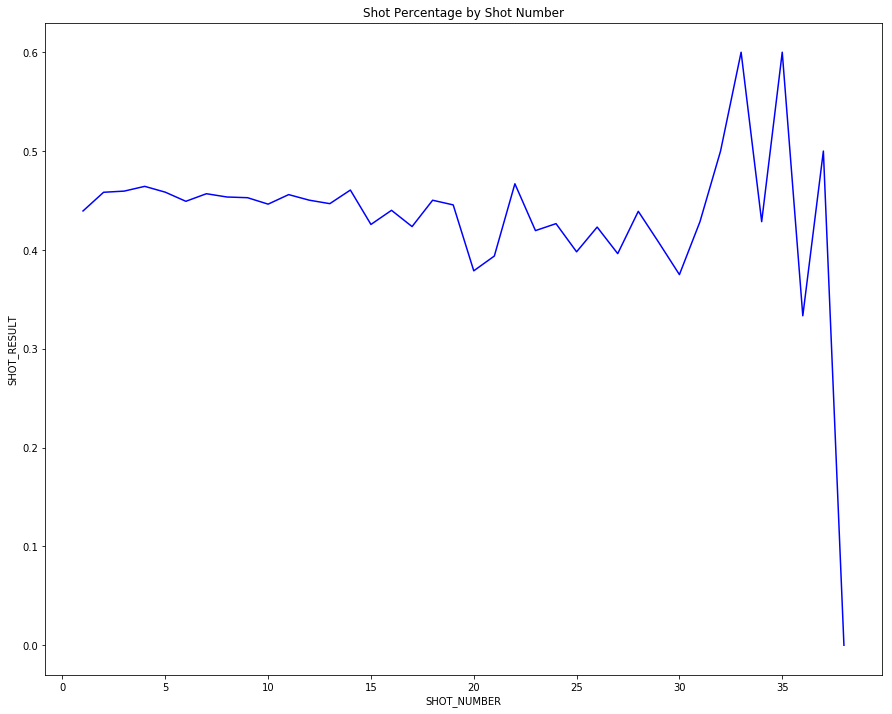

In [23]:
# comparing makes and misses for shot number.  Usually when a player takes many shots, they have been doing
# well up until that point and usually star players, so it is possible that the higher the shot number is, the
# more likely it is for that shot to go in.

plt.figure(figsize = (15,12))
sns.lineplot(x = shot.SHOT_NUMBER, y = shot.SHOT_RESULT, ci = None, color = 'blue')
plt.title('Shot Percentage by Shot Number')
plt.show()

In [24]:
print(sum(shot.SHOT_NUMBER == 32), sum(shot.SHOT_NUMBER == 33), sum(shot.SHOT_NUMBER == 35),sum(shot.SHOT_NUMBER == 37))

12 10 5 2


Looking at the lineplot, it seems that the shot number generally does not affect whether or not the shot was made up until maybe around shot 19.  This could be due to the fact that there is so much less data for shots after a certain point.  After shot 19, the percentage of shots made seems to vary more drastically, and even moreso after shot 31.  

While it seems like shot numbers 32, 33, 35, and 37 may have higher chances of going in, looking at the tiny amount of shots taken at that shot number, this is more likely a result of random chance.  There does not seem to be enough evidence to say for certain that the higher the shot number, the more likely for the shot to be made.

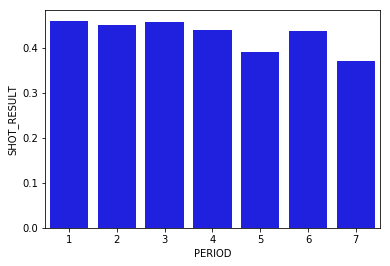

In [25]:
#comparing makes and misses for game period

sns.barplot(x = shot.PERIOD, y = shot.SHOT_RESULT, ci = None, color = 'blue')

In [26]:
print(sum(shot.PERIOD == 5), sum(shot.PERIOD == 6), sum(shot.PERIOD == 7))

911 167 43


It seems that the percentage of shot made does not vary too much within the first 4 quarters, though the 4th period seems to have lower shot percentage.  The overtime periods (5,6, and 7) all have lower percentages, with periods 5 and 7 being much lower.  Their total amount of shots taken at 911 and 43 represents a decent size.  Furthermore, in an overtime period, players are much more tired compared to the first 4 quarters, so their shot percentages should naturally drop.

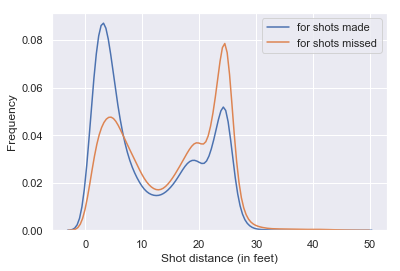

In [27]:
# two line histograms of shot distances
# this plot measures the exact same thing as the frequency plot for
# shot_dist from the pairplot, but it is more zoomed in and shown as
# a line histogram rather than a histogram.
sns.set()
sns.distplot(shot_made['SHOT_DIST'], hist = False, label = 'for shots made')
sns.distplot(shot_missed['SHOT_DIST'], hist = False, label = 'for shots missed')
plt.ylabel('Frequency')
plt.xlabel('Shot distance (in feet)')
plt.show()

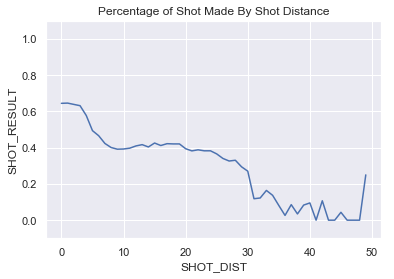

In [28]:
# plot percentages of shot made by shot distance
# binning shot_distance with pd.cut for a smoother plot
sns.lineplot(x = pd.cut(shot.SHOT_DIST, 50, labels = False), y = shot.SHOT_RESULT, ci = None)
plt.ylim([-.1,1.1])
plt.title('Percentage of Shot Made By Shot Distance')
plt.show()

 The two distributions are definitely different, with, as expected, more shots being made the closer the shot is taken to the rim.  Of note is the two peaks at the same distance for both line histograms.  The first peak represents shots taken close to the rim, meaning probably layups or dunks.  The second peak represents the distance for a three point shot.  The little bump in the second peak most likely represents corner three point shots, which are closer to the rim than other three point shots.

 Furthermore, as shown by the line plot, there is an obvious decrease in shot made percentage as shot distance increases, even though the plot shows outliers with extremely large distances.

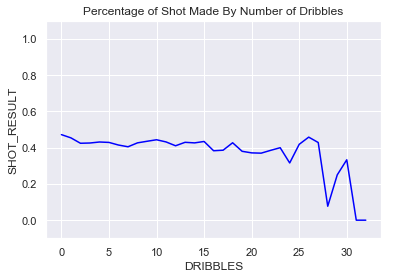

In [29]:
#plot the dribbles bar chart
sns.lineplot(x = shot.DRIBBLES, y = shot.SHOT_RESULT, ci = None, color = 'blue')
plt.title('Percentage of Shot Made By Number of Dribbles')
plt.ylim([-.1,1.1])
plt.show()

In [30]:
print(sum(shot.DRIBBLES == 22), sum(shot.DRIBBLES == 23), sum(shot.DRIBBLES == 24), sum(shot.DRIBBLES == 28), sum(shot.DRIBBLES == 29))

96 100 57 13 4


I chose to use a line chart so I can try to how the percentages for shots made and missed vary for each dribble taken, and it is less messy than a bar chart. Starting from 22 dribbles and on, there are 100 or less total shots taken for each dribble number.  Therefore, the I decided to leave them out as taking that many dribbles is very uncommon.  As can be shown from the plot, it seems that the more dribbles a player takes, the less likely it becomes for him to make a shot, although this effect is pretty small.  With 18 dribbles, the shot made percentage seems to be a bit high for the trend, and between 8 and 12 dribbles inclusive, there seems to be a little bump in the overall trend of decreasing shot made percentage.  While taking less dribbles does increase shot percentage, it does not seem to be a major factor.

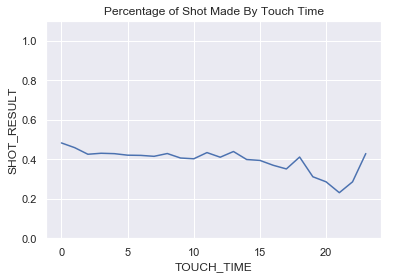

In [31]:
# plot percentages of shot made by closest defender distance
# binning CLOSE_DEF_DIST with pd.cut for a smoother plot
sns.lineplot(x = pd.cut(shot.TOUCH_TIME, 24, labels = False), y = shot.SHOT_RESULT, ci = None)
plt.ylim([0,1.1])
plt.title('Percentage of Shot Made By Touch Time')
plt.show()

In [32]:
print(sum(shot.TOUCH_TIME < 15), sum(shot.TOUCH_TIME >= 15))

126761 1228


The shot percentage seems to be at its highest at 0 seconds and decreases up until 2 seconds, when it flattens out.  This makes sense as shots in this range would be catch and shoot, which generally have a higher percentage.  The shot percentage is about the same until about 15 seconds, and then it starts to vary greatly.  However, with relatively little data after 15 seconds, this variation is not as certain as the plateau from between 2 and 15 seconds.

Despite having the same theoritical range as shot clock, touch time has outliers starting from around 15, as it is rare for a single player to hold the ball for that long without passing.

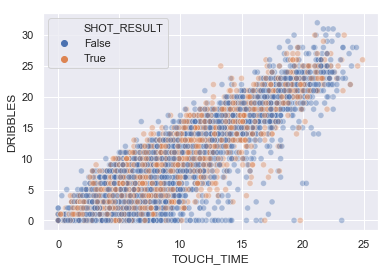

In [33]:
#bigger version of scatter plot of touch time and dribbles

sns.scatterplot(x = shot.TOUCH_TIME, y = shot.DRIBBLES, hue = shot.SHOT_RESULT, alpha = .4)
plt.show()

There is definitely a strong relationship between touch time and shot result, which could present troubles in a final model.  However, the correlation is far from perfect, and there are plenty of observations with a long touch time, but no dribbles, so it would be ok to use both in a final model.

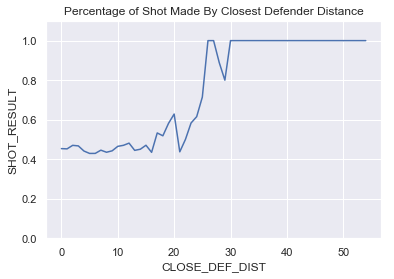

In [34]:
# plot percentages of shot made by closest defender distance
# binning CLOSE_DEF_DIST with pd.cut for a smoother plot
sns.lineplot(x = pd.cut(shot.CLOSE_DEF_DIST, 55, labels = False), y = shot.SHOT_RESULT, ci = None)
plt.ylim([0,1.1])
plt.title('Percentage of Shot Made By Closest Defender Distance')
plt.show()

In [35]:
print(sum(shot.CLOSE_DEF_DIST < 20), sum(shot.CLOSE_DEF_DIST >= 20))

127807 182


There seems to be a general increase in shot made percentage with a bigger distance of the closest defender.  However, with such little data after a distance of 20, these shots are very rare.

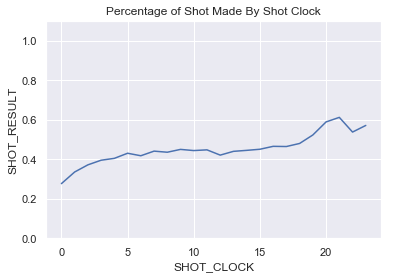

In [36]:
# plot percentages of shot made by time on shot clock
# binning shot_clock with pd.cut for a smoother plot
sns.lineplot(x = pd.cut(shot.SHOT_CLOCK, 24, labels = False), y = shot.SHOT_RESULT, ci = None)
plt.ylim([0,1.1])
plt.title('Percentage of Shot Made By Shot Clock')
plt.show()

In [37]:
print(sum(shot.SHOT_CLOCK < 5), sum((shot.SHOT_CLOCK >= 5) & (shot.SHOT_CLOCK < 18)), sum(shot.SHOT_CLOCK > 18))

13050 91121 22898


It seems that when the shot clock is above 18 seconds, there the shot percentage is pretty high.  This makes sense as these are shots taken on the fast break, or when the defenses haven't been set yet.  Then, between 5 seconds and 18 seconds, the shot percentage remains about the same.  For shots taken with less than 5 seconds left, the percentage is relatively low, which makes sense as shots taken around here would be last second and rushed shots.

Unlike most other variables, this one does not have any outliers because teams are usually in position to take as long as the shot clock allows they want to get a shot off.

Now that the eda has provided a better view of the data, it is time to test different models to see which model will provide the highest accuracy.

In [38]:
#importing necessary packages for modeling

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [39]:
shot.head()

,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSE_DEF_DIST,PTS
0,1,1,1.09,10.800000,2,1.9,7.7,2,True,1.3,2
1,2,1,0.14,3.400000,0,0.8,28.2,3,False,6.1,0
2,3,1,0.00,12.453399,3,2.7,10.1,2,False,0.9,0
3,4,2,11.47,10.300000,2,1.9,17.2,2,False,3.4,0
4,5,2,10.34,10.900000,2,2.7,3.7,2,False,1.1,0


In [40]:
#modeling

# create and isolate list of shot_results as boolean
shot_y = shot.SHOT_RESULT

#create dataframe of independent variables 
shot_X = shot[['SHOT_NUMBER', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK',
               'SHOT_DIST', 'CLOSE_DEF_DIST', 'PTS_TYPE', 'PERIOD', 'GAME_CLOCK']]

In [41]:
kbest = SelectKBest(chi2, k = 4).fit(shot_X, shot_y)
kbest.scores_

array([3.05372906e+01, 9.15682829e+02, 9.34696292e+02, 2.93647971e+03,
       2.74559739e+04, 1.09177506e-01, 1.61491367e+02, 1.35548065e+01,
       2.90951568e+01])

In [42]:
# split data into training and testing. The testing data will be used at the end to find out accuracy

Xtrain, Xtest, ytrain, ytest = train_test_split(shot_X, shot_y, test_size = .25,
                                               random_state = 99)

With the training and test set separated, I will now look use different algorithms with cross validation to compare which ones provide the best results.

In [43]:
%%time

# first trying a logistic regression 
# choosing to not fit an intercept because it is literally impossible for all variables to be 0, so the intercept
# would not be meaningful.

lr = LogisticRegression(fit_intercept = False)

# array of hyper-parameter c to see which works best
Cs = [.00001, .0001, 0.001, .01, 0.1, 1]
parameterslr = {'C' : Cs}
cgridlr = GridSearchCV(lr, param_grid = parameterslr, cv = 5)
cgridlr.fit(Xtrain, ytrain)
print(cgridlr.best_estimator_, cgridlr.best_params_, cgridlr.best_score_, cgridlr.grid_scores_)

LogisticRegression(C=1e-05, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) {'C': 1e-05} 0.6106509985311123 [mean: 0.61065, std: 0.00450, params: {'C': 1e-05}, mean: 0.60941, std: 0.00510, params: {'C': 0.0001}, mean: 0.60834, std: 0.00493, params: {'C': 0.001}, mean: 0.60802, std: 0.00486, params: {'C': 0.01}, mean: 0.60786, std: 0.00484, params: {'C': 0.1}, mean: 0.60781, std: 0.00484, params: {'C': 1}]
CPU times: user 19.9 s, sys: 702 ms, total: 20.6 s
Wall time: 5.22 s


/Users/ray/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


From these scores, we see that using a regularization parameter of .00001 results in the highest mean accuracy (.611) taken across each of the 5 cross validation folds.  

In [44]:
%%time
# using grid scored-picked C hyperparameter for the model to test accuracy

cgridlr.score(Xtest, ytest)

CPU times: user 23.6 ms, sys: 5.01 ms, total: 28.6 ms
Wall time: 6.67 ms


0.6096631039439965

Logistic regression models a binary dependent variable by estimating the effects of the predictor variables on the log-odds of the dependent variable.  This model would seem appropriate as our predicted variable, shot_made, is binary.  The accuracy of 61% implies that, for the test set, 61% of the observations resulted in a log-odds probability of the dependent variable being closer to the observed value rather than its opposite. 

In [45]:
%%time
# trying a linear regression
# choosing to not fit an intercept for the same reason as above

linr = LinearRegression(fit_intercept = False)

linr.fit(Xtrain, ytrain)

CPU times: user 242 ms, sys: 43.6 ms, total: 286 ms
Wall time: 91.4 ms


In [46]:
%%time

#measuring accuracy for linear regression
linr.score(Xtest, ytest)

CPU times: user 10.9 ms, sys: 2.42 ms, total: 13.4 ms
Wall time: 2.99 ms


0.03587035387324433

Similar to logistic regression, linear regression models a dependent variable using predictor variables.  Unlike logistic regression, the predicted variable does not need to be dependent, but is typically a continous numerical value.  It is a poor fit to estimate whether or not the shot was made, as can be shown by the extremely low accuracy score.

In [47]:
%%time

# trying a decision tree algorithm
parameterstree = {
    'max_depth': [20, 50, 100, 120],
    'max_features': [2, 3, 4, 5, 6],
    'min_samples_leaf': [.01, .03, .05, .1],
    'min_samples_split': [.01, .03, .05, .1],
}

tree = DecisionTreeClassifier(random_state = 99)
cgridtree = GridSearchCV(tree, param_grid = parameterstree, cv = 5)
cgridtree.fit(Xtrain, ytrain)
print(cgridtree.best_estimator_, cgridtree.best_params_, cgridtree.best_score_)

#print('DecisionTree: Area under the ROC curve = {}'.format(tree_performance))
#tree_preds = tree.predict_proba(Xtest)[:, 1]
#tree_performance = roc_auc_score(ytest, tree_preds)
#grid_search.best_params_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
            max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=0.01,
            min_samples_split=0.05, min_weight_fraction_leaf=0.0,
            presort=False, random_state=99, splitter='best') {'max_depth': 20, 'max_features': 4, 'min_samples_leaf': 0.01, 'min_samples_split': 0.05} 0.6178183371357732
CPU times: user 1min 37s, sys: 1.81 s, total: 1min 39s
Wall time: 1min 38s


In [48]:
%%time

# accuracy for decision tree algorithm

cgridtree.score(Xtest, ytest)

CPU times: user 5.19 ms, sys: 1.81 ms, total: 7 ms
Wall time: 5.18 ms


0.6183823988999313

Decision trees look at thresholds of a feature, or the independent variables to make decisions (the branch) that end in a prediction of the dependent variable (the leaf node).  They are very interpretable, but are relatively inaccurate and prone to overfitting.  This accuracy means that 61.5% of the observations in the final leaf nodes followed the correct branches.

In [49]:
%%time

# trying a random forest algorithm
parametersrf = {
    'max_depth': [20, 50, 100, 120],
    'max_features': [2, 3, 4, 5, 6],
    'min_samples_leaf': [.01, .03, .05, .1],
    'min_samples_split': [.01, .03, .05, .1],
    'bootstrap': [True, False],
    'n_estimators': [10, 100, 200]
}
rf = RandomForestClassifier(random_state = 99)

# using randomized search to greatly reduce training speed
rgridrf = RandomizedSearchCV(estimator = rf, param_distributions  = parametersrf)
rgridrf.fit(Xtrain, ytrain)
print(rgridrf.best_estimator_, rgridrf.best_params_, rgridrf.best_score_)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=120, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.01, min_samples_split=0.01,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=99, verbose=0, warm_start=False) {'n_estimators': 100, 'min_samples_split': 0.01, 'min_samples_leaf': 0.01, 'max_features': 5, 'max_depth': 120, 'bootstrap': False} 0.6183913075184132
CPU times: user 2min 42s, sys: 257 ms, total: 2min 42s
Wall time: 2min 42s


In [50]:
%%time

#accuracy for random forest
rgridrf.score(Xtest, ytest)

CPU times: user 243 ms, sys: 2.28 ms, total: 245 ms
Wall time: 244 ms


0.6187574223388962

A random forest algorithm is the aggregation of many decision trees.  These different decision trees are all fit to the data, and the random forest takes the mean of the classifications of the individual trees.  Random forests are therefore more robust to overfitting.

In [51]:
%%time

# trying a Gaussian naive bayes algorithm
gnb = GaussianNB()
gnb.fit(Xtrain, ytrain)

CPU times: user 22.4 ms, sys: 5.04 ms, total: 27.5 ms
Wall time: 25.9 ms


In [52]:
%%time

# Gaussian naive bayes accuracy
gnb.score(Xtest, ytest)

CPU times: user 7.09 ms, sys: 2.01 ms, total: 9.1 ms
Wall time: 7.95 ms


0.5799112444527783

A naive Bayes classifier uses Baye's theorem and an assumption that the features are independent to give a probability of an observation belonging to a certain class.  Like logistic regression, the naive Bayes classifier gives a probability distribution of the output, so a 58% accuracy means that the probabilities of 58% of these observations are closer to the actual observed outcome rather than the opposite.

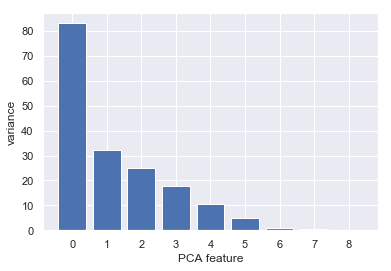

In [53]:
# trying a support vector classification
# using pca to reduce training time


# first use pca plot to reduce dimensionality

pca = PCA()
pca.fit(Xtrain)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

It seems that 4 would be the optimal amount of components to use for the pca.

In [54]:
#%%time

#svc = SVC(random_state = 99)
#pca = PCA(n_components = 4)

#pipe = Pipeline(steps=[('pca', pca), ('svc', svc)])

# Parameters for svc
#parameterssvc = {
#    'svc__C': [0.001, .01, 0.1],
#}

#pcacgridsvc = GridSearchCV(pipe, param_grid = parameterssvc, cv=5)
#pcacgridsvc.fit(Xtrain, ytrain)

In [55]:
%%time

svc = SVC(C = .01, kernel = 'linear', random_state = 99)
pca = PCA(n_components = 4)

pipesvc = Pipeline(steps=[('pca', pca), ('svc', svc)])
pipesvc.fit(Xtrain, ytrain)

CPU times: user 2min 16s, sys: 2.19 s, total: 2min 18s
Wall time: 2min 18s


In [56]:
%%time

pipesvc.score(Xtest, ytest)

CPU times: user 15.6 s, sys: 66.8 ms, total: 15.7 s
Wall time: 15.1 s


0.5860678792424526

A support vector classifier is an algorithm that finds the maximum distance between two classes on a hyperplane, and places new observations on either side of that maximum distance gap. An accuracy score of 58.6% means that 58.6% of the observations were placed on the correct side of the gap and therefore classed correctly.

In [57]:
%%time

#using xgboost

xgb = XGBClassifier()
#parametersxgb = {
#    'max_depth': [20, 50, 80],
#    'min_child_weight': [1, 5, 10],
#    'gamma': [0.5, 1, 2, 5]
#}
pca = PCA(n_components = 4)

pipexgb = Pipeline(steps=[('pca', pca), ('xgb', xgb)])
pipexgb.fit(Xtrain, ytrain)

#cgridxgb = RandomizedSearchCV(estimator = xgb, param_distributions = parametersxgb, cv = 5)
#cgridxgb.fit(Xtrain, ytrain)
#print(cgridxgb.best_estimator_, cgridxgb.best_params_, cgridxgb.best_score_)

CPU times: user 3.55 s, sys: 61.5 ms, total: 3.61 s
Wall time: 2.76 s


In [58]:
%%time

pipexgb.score(Xtest, ytest)

CPU times: user 264 ms, sys: 10.4 ms, total: 275 ms
Wall time: 70.7 ms


/Users/ray/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6095380961310082

XGBoost is an ensemble method that takes weaker algorithms which, in this case, are decision trees and improves them with respect to a distribution and adds them onto the final, stronger algorithm.  The iteratively added algorithms are weighed according to accuracy where misclassified input have higher weights.  The future algorythms forcus on the areas where previous algorithms have done poorly

Table for the accuracy, training time, and testing time of the different algorithms

| Algorithm     | Accuracy  |  Training Time | Testing Time |
| :-------------: |:-------------:|:-------------:|:-------------:|
| Logistic Regression  | 0.6099131195699731  | 18 s      | 26.6 ms | 
| Linear Regression    | 0.03322966785373416 | 184 ms    | 12.3 ms | 
| Decision Tree        | 0.6154447152947059  | 7min 43s  | 29.1 ms | 
| Random Forest        | 0.6161947621726358  | 2min 4s   | 193 ms  |
| Gaussian Naive Bayes | 0.5802550159384962  | 104 ms    | 30.1 ms ms |
| Support Vector Classification | 0.5860053753359585 | 2min 25s | 14.7 s |
| XGBoost              | 0.6092568285517845  |  3.76 s   | 287 ms|